In [11]:
import sys
import os
import time
sys.path.append(os.path.abspath('../..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 28,         
    'axes.labelsize': 28,    
    'axes.titlesize': 30,      # <-- Add this line for title size
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 5,    
    'lines.markersize': 6   
})

In [2]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    shared_component = base_strength * np.ones((d, r))
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

In [3]:
def uniform_outliers(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N * D
    num_outliers = int(np.round(percent_outliers * total_elements))

    indices = np.unravel_index(
        np.random.choice(total_elements, num_outliers, replace=False),
        (N, D)
    )

    signs = np.random.choice([-1, 1], size=num_outliers)

    uniform_values = np.random.uniform(start, end, size=num_outliers) * signs

    Y_outliers[indices] += uniform_values

    return Y_outliers

def uniform_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N 
    num_outliers = int(np.round(percent_outliers * total_elements))

    row_indices = np.random.choice(N, num_outliers, replace=False)
    col_indices = np.zeros(num_outliers, dtype=int) 

    signs = np.random.choice([-1, 1], size=num_outliers)

    uniform_values = np.random.uniform(start, end, size=num_outliers) * signs

    Y_outliers[row_indices, col_indices] += uniform_values

    return Y_outliers

def asymmetric_outliers(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N * D
    num_outliers = int(np.round(percent_outliers * total_elements))

    indices = np.unravel_index(
        np.random.choice(total_elements, num_outliers, replace=False),
        (N, D)
    )

    uniform_values = np.random.uniform(start, end, size=num_outliers)

    Y_outliers[indices] += uniform_values

    return Y_outliers

def asymmetric_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")
    
    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N 
    num_outliers = int(np.round(percent_outliers * total_elements))

    row_indices = np.random.choice(N, num_outliers, replace=False)
    col_indices = np.zeros(num_outliers, dtype=int) 

    uniform_values = np.random.uniform(start, end, size=num_outliers)

    Y_outliers[row_indices, col_indices] += uniform_values

    return Y_outliers

def focused_outliers(X, Y, percent_outliers, y_value):
    X = X.copy()
    Y = Y.copy()

    n_samples = X.shape[0]
    n_outliers = int(n_samples * percent_outliers)

    indices = np.random.choice(n_samples, size=n_outliers, replace=False)
    medians = np.median(X, axis=0)

    for idx in indices:
        Y[idx, 0] = y_value
        X[idx] = medians

    return X, Y

## Toy example

In [4]:
def sample_icm_rbf(X, *, lengthscale=1.0, B=None, noise_variance=0.0, jitter=1e-6, random_state=None):

    X = np.asarray(X, dtype=float).reshape(-1, 1)
    n = X.shape[0]

    if B is None:
        B = np.array([[1.0, 0.7],
                      [0.7, 1.0]])

    sq_dists = (X - X.T) ** 2
    Kx = np.exp(-0.5 * sq_dists / lengthscale ** 2)      

    K = np.kron(B, Kx)                                   
    K += jitter * np.eye(K.shape[0])                      

    rng = np.random.default_rng(random_state)
    y = rng.multivariate_normal(np.zeros(K.shape[0]), K)   
    y = y.reshape(2, n).T                              

    noise_variance = np.asarray(noise_variance, dtype=float)
    if noise_variance.ndim == 0:
        y += rng.normal(scale=np.sqrt(noise_variance), size=y.shape)
    elif noise_variance.ndim == 1 and noise_variance.shape[0] == 2:
        scales = np.sqrt(noise_variance)[None, :]        
        y += rng.normal(scale=scales, size=y.shape)
    else:
        raise ValueError("noise_variance must be a scalar or length‑2 array")

    return y 

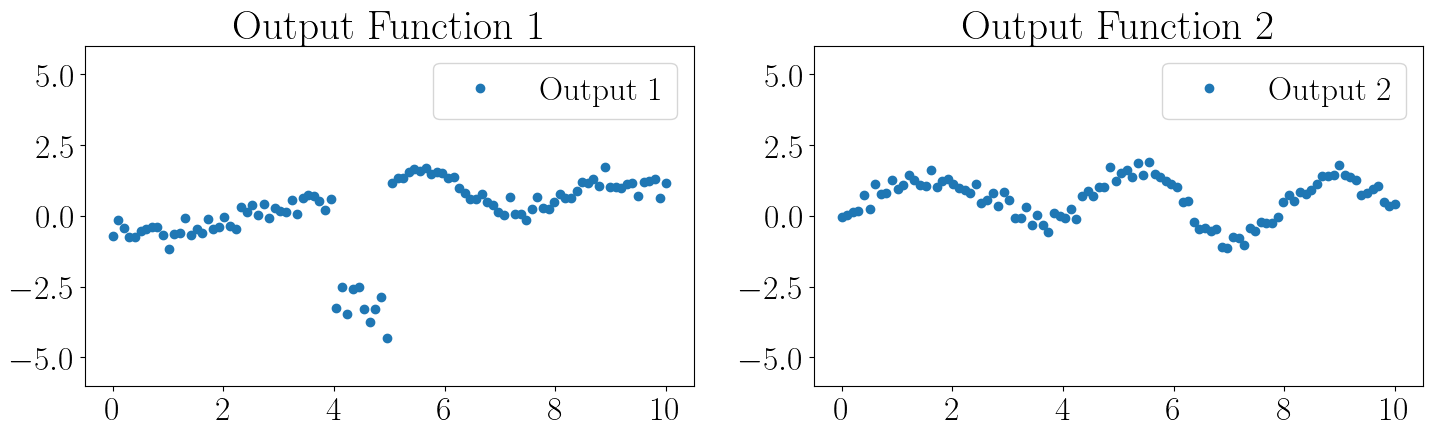

In [5]:
np.random.seed(42)
N = 100
D = 2

X = np.linspace(0.0, 10, N)
Y = sample_icm_rbf(X, lengthscale=1, noise_variance=0.05, random_state=41)

# Outliers
outlier_range = np.where((X >= 4) & (X <= 5))[0]
outlier_indices = np.random.choice(outlier_range, int(10), replace=False)
Y[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(X.flatten(), Y[:, i], 'o', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

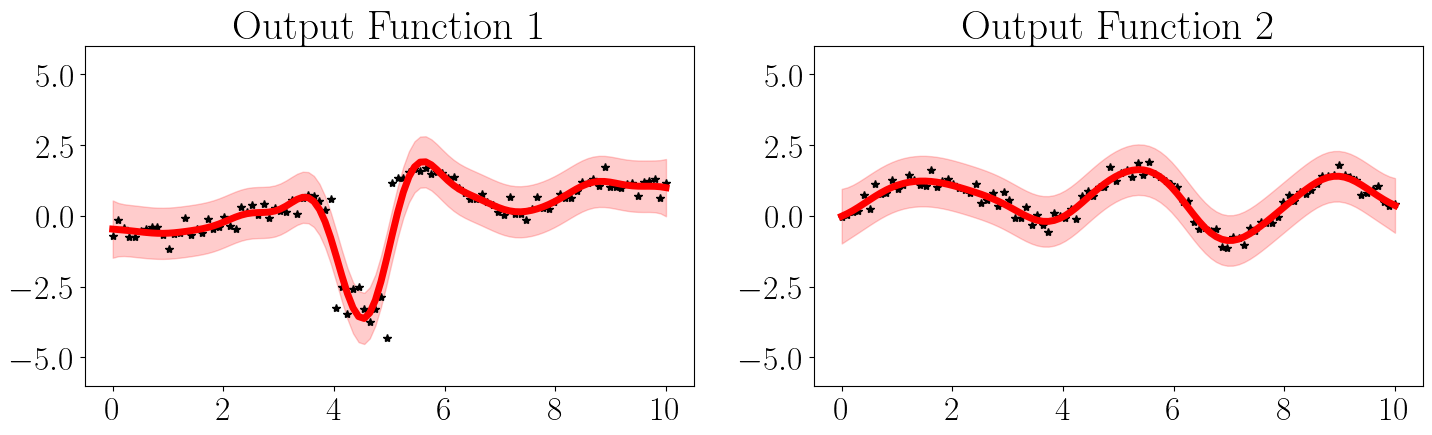

In [6]:
# mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=np.array([[1, 0.7], [0.7, 1]]))
mogp.fit(X.reshape(-1,1), Y)

# Optimize hyperparameters
mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 10, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(X.flatten(), Y[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

# Energy Efficiency Dataset

In [14]:
import pandas as pd

# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Read Excel file directly from the URL
df = pd.read_excel(url)

# Extract covariates X (columns X1 to X8)
X = df.loc[:, 'X1':'X8'].to_numpy()

# Extract target variables Y (columns Y1 and Y2)
Y = df.loc[:, ['Y1', 'Y2']].to_numpy()

# Split data into train and test sets (default test size = 25%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)

empty_noise = np.array([1e-6]*2)

## No outliers

In [8]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [9]:
initial_A = generate_A(d = 2, r = 2)

# Measure total time
start_total = time.time()

mogp = MOGPRegressor_NC(mean=0, length_scale=1.67, noise=0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)

end_total = time.time()

print(f"Total runtime: {end_total - start_total:.4f} seconds")

Total runtime: 264.1738 seconds


In [22]:
# Measure total time
start_total = time.time()

mcd = MinCovDet(support_fraction=1.0).fit(Y_train_scaled)
robust_covariance = mcd.covariance_

morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=1.67, noise = 0.04, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=robust_covariance, noise_weighted=1e-7)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")

Total runtime: 61.0630 seconds


In [23]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.11624258762614825
RMSE MORCGP: 0.16905871724511456
NLPD MOGP: -0.8026896207863814
NLPD MORCGP: -0.3079874652156318


## Uniform outliers

In [24]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

Y_train_scaled = uniform_outliers_c1(Y=Y_train_scaled, percent_outliers=0.1, start=2, end=3)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [25]:
initial_A = generate_A(d = 2, r = 2)

start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)

end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")

Fitted data
Optimized hyperparameters
Total runtime: 290.0159 seconds


In [26]:
start_total = time.time()

mcd = MinCovDet(support_fraction=1.0).fit(Y_train_scaled)
robust_covariance = mcd.covariance_

morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=robust_covariance, noise_weighted=1e-7)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)


mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")

Optimized length_scale: 1.7160, noise: 0.038219
Optimized A: [[0.63361095 0.75978329]
 [0.62024954 0.6962558 ]]
Optimized B: 
[[0.97873349 0.92200042]
 [0.92200042 0.86948163]]
Total runtime: 34.0511 seconds


In [27]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.26936929314899627
RMSE MORCGP: 0.19281397196291183
NLPD MOGP: 0.5429757782614072
NLPD MORCGP: -0.23021570290387924


In [ ]:
print('mu_mogp', mu_mogp.reshape(-1)[:6])
print('mu_morcgp', mu_morcgp.reshape(-1)[:6])
print('true test', Y_test_scaled.reshape(-1)[:6])
print('true train', Y_train_scaled.reshape(-1)[:6])
print('init_pred_mean:', initial_predictive_mean.reshape(-1)[:6])
print('init_pred_var:', initial_predictive_variances.reshape(-1)[:6])
print('pred_mean:', predictive_mean.reshape(-1)[:6])
print('pred_var:', predictive_variances.reshape(-1)[:6])

## Asymmetric outliers

In [37]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

Y_train_scaled = asymmetric_outliers_c1(Y=Y_train_scaled, percent_outliers=0.1, start=6, end=9)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [38]:
initial_A = generate_A(d = 2, r = 2)
start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")

Fitted data
Optimized hyperparameters


KeyboardInterrupt: 

In [39]:
start_total = time.time()

mcd = MinCovDet(support_fraction=0.9).fit(Y_train_scaled)
robust_covariance = mcd.covariance_

morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=robust_covariance, noise_weighted=1e-7)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

print('Optimized hyperparameters')


mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")

Optimized length_scale: 1.7290, noise: 0.038256
Optimized A: [[0.78065625 0.71303206]
 [0.67573456 0.63214809]]
Optimized B: 
[[1.1178389  0.97825826]
 [0.97825826 0.8562284 ]]
Optimized hyperparameters
Total runtime: 33.8284 seconds


In [40]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.337396011569134
RMSE MORCGP: 0.1975652673464742
NLPD MOGP: 0.5725390258835238
NLPD MORCGP: -0.20653474419754966


## Focused outliers

In [ ]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

X_train_scaled, Y_train_scaled = focused_outliers(X=X_train_scaled, Y=Y_train_scaled, percent_outliers=0.1, y_value=4)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

In [ ]:
print(Y_train_scaled[22, 0].reshape(-1))
print(X_train_scaled[22, :].reshape(-1)[:6])
print(Y_train_scaled[25, 0].reshape(-1))
print(X_train_scaled[25, :].reshape(-1)[:6])

In [ ]:
initial_A = generate_A(d = 2, r = 2)
start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

In [ ]:
cov_matrix = np.cov(Y_train_scaled, rowvar=False)
print(cov_matrix)

start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

print('Optimized hyperparameters')

start_pred = time.time()

mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

In [ ]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

N_test, D = Y_train_scaled.shape
data = {
    "Value": np.concatenate([Y_train_scaled.flatten(), Y_train_scaled.flatten()]),
    "Type": ["True"] * (N_test * D) + ["Predicted"] * (N_test * D),
    "Dimension": [f"D{i+1}" for i in range(D)] * N_test * 2
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x="Dimension", y="Value", hue="Type", data=df, split=True)
plt.title("Violin Plot of True vs Predicted Values")
plt.ylabel("Value")
plt.xlabel("Output Dimension")
plt.legend(title="Legend")
plt.tight_layout()
plt.ylim(-3,6)
plt.show()
